## CNNs for image emulation

The code illustrates how to use CNNs for image emulation. The emulator learns to generate images of correlated gaussian distributions. It is a very trivial toy example but shows the kind of thing that might be used for 21-cm tomography and power spectra estimation in the future.  An example application of CNNs to learn the 2D 21-cm power spectrum can be found in https://arxiv.org/abs/2309.05697.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

### Training and test data

We first have to generate some images to train on. One can imagine this being a set of images from a complex semi-numerical simulation of the 21-cm signal. Here I am generating samples from a 2D Gaussian distribution with random means and covariances, histogramming the samples and effectively assigning the bin height to the pixel intensity. I have 16 bins in my histogram which corresponds to a (16 x 16) pixel image. The means and covariances of my multivariate gaussian are saved as the inputs to my network. In a real example the inputs might be cosmological describing the star formation rate of early galaxies or the expansion rate of the Universe.

I split the dataset into training and test examples for validation.

Typically CNNs perform quite well without any kind of normalisation to the input data and target images although this can of course be done.

In [2]:

def generator(params):
    signal = np.random.multivariate_normal([params[0], params[1]],
                [[params[2], params[3]],[params[4], params[2]]], 1000)
    return signal

def prior(n):
    theta = np.zeros((n, 5))
    theta[:, 0] = np.random.uniform(-1, 1, n) # mean 1
    theta[:, 1] = np.random.uniform(-1, 1, n) # mean 2
    theta[:, 2] = np.random.uniform(0, 0.5, n) # standard deviation
    theta[:, 3] = np.random.uniform(0, 0.5, n) # cov1
    theta[:, 4] = np.random.uniform(0, 0.5, n) # cov2
    return theta

samples = prior(10000)
signals = []
for i in tqdm(range(len(samples))):
    signal = generator(samples[i])
    H, xedges, yedges = np.histogram2d(signal[:, 0], signal[:, 1], 
                range=[[-3, 3], [-3, 3]], bins=16)
    signals.append(H)
signals = np.array(signals)

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(samples, signals, 
                        test_size=0.2, random_state=42)

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/pk/s11gmpgj1_d0jt1ykgfx7rt80000gn/T/ipykernel_1676/2206126262.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  signal = np.random.multivariate_normal([params[0], params[1]],
100%|██████████| 10000/10000 [00:01<00:00, 6536.58it/s]


### Building the networks

Next I define two different neural networks to emulate the multivariate gaussian images I generated earlier. The first uses convolutional layers to build up complexity in the image where as the latter just uses dense layers and reshapes the ouput of the final layer into a (16 x16) image. The idea is to demonstrate how powerful the convolutional layers are.

I train the networks with early stopping and use a pixel by pixel absolute error loss function between the network output and the example training data.

In [3]:

def loss(y_true, y_pred):
    #print(y_pred)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    return tf.reduce_mean(tf.math.abs(y_true -y_pred))

model_cnn = tf.keras.models.Sequential([
  # dense layers from parameters to pixels
  tf.keras.layers.Dense(3, activation='tanh'),
  tf.keras.layers.Dense(10, activation='tanh'),
  tf.keras.layers.Dense(32, activation='tanh'),
  tf.keras.layers.Dense(32, activation='tanh'),
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(256, activation='tanh'),
  # reshape into 16 by 16 array or image
  tf.keras.layers.Reshape((16, 16, 1)),
  # upsample it using some interpolation to 32 by 32
  tf.keras.layers.UpSampling2D((2, 2), interpolation='bicubic'),
  # expand it into a cube with layers
  tf.keras.layers.Conv2D(3, (2, 2)),
  # convolve it back down to an image for pixel by pixel loss
  tf.keras.layers.Conv2D(2, (16, 16)),
  tf.keras.layers.Conv2D(1, (1, 1))
])

model_no_cnn = tf.keras.models.Sequential([
  # dense layers from parameters to pixels
  tf.keras.layers.Dense(3, activation='tanh'),
  tf.keras.layers.Dense(10, activation='tanh'),
  tf.keras.layers.Dense(32, activation='tanh'),
  tf.keras.layers.Dense(32, activation='tanh'),
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(256, activation='tanh'),
  # reshape into 16 by 16 array or image
  tf.keras.layers.Reshape((16, 16, 1))
])

# building the model with the adam optimizer and mean squared error loss function
model_cnn.compile(optimizer='adam',
              loss=loss,)

# building the model with the adam optimizer and mean squared error loss function
model_no_cnn.compile(optimizer='adam',
              loss=loss,)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# training the model
model_cnn.fit(samples, signals, epochs=500, batch_size=250,
          callbacks=[callback], validation_data=(test_data, test_labels))

# training the model
model_no_cnn.fit(samples, signals, epochs=500, batch_size=250,
          callbacks=[callback], validation_data=(test_data, test_labels))

Epoch 1/500
40/40 [==============================] - 2s 32ms/step - loss: 3.8952 - val_loss: 3.8077
Epoch 2/500
40/40 [==============================] - 1s 34ms/step - loss: 3.5549 - val_loss: 3.3651
Epoch 3/500
40/40 [==============================] - 1s 32ms/step - loss: 3.2668 - val_loss: 3.1478
Epoch 4/500
40/40 [==============================] - 1s 30ms/step - loss: 3.0685 - val_loss: 2.9589
Epoch 5/500
40/40 [==============================] - 1s 30ms/step - loss: 2.9004 - val_loss: 2.8005
Epoch 6/500
40/40 [==============================] - 1s 30ms/step - loss: 2.7569 - val_loss: 2.6768
Epoch 7/500
40/40 [==============================] - 1s 31ms/step - loss: 2.6520 - val_loss: 2.5908
Epoch 8/500
40/40 [==============================] - 1s 30ms/step - loss: 2.5781 - val_loss: 2.5251
Epoch 9/500
40/40 [==============================] - 1s 30ms/step - loss: 2.5196 - val_loss: 2.4706
Epoch 10/500
40/40 [==============================] - 1s 30ms/step - loss: 2.4708 - val_loss: 2.4265

100%|██████████| 2000/2000 [01:06<00:00, 30.22it/s]

Mean CNN Loss:  0.019771309954066715
Mean No CNN Loss:  0.044503638365442785


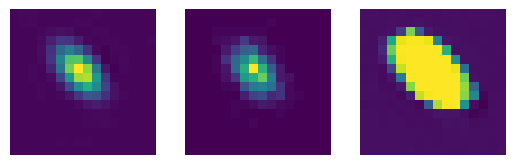

In [5]:

def error(true, pred):
    return np.mean(np.abs(true - pred)/np.max(true)*100)

pred_cnn = []
pred_no_cnn = []
loss_cnn = []
loss_no_cnn = []
for i in tqdm(range(len(test_data))):
    pred_cnn.append(model_cnn.predict(test_data[i].reshape(1, -1), verbose=0).reshape(16, 16))
    pred_no_cnn.append(model_no_cnn.predict(test_data[i].reshape(1, -1), verbose=0).reshape(16, 16))
    loss_cnn.append(error(test_labels[i], pred_cnn[i]))
    loss_no_cnn.append(error(test_labels[i], pred_no_cnn[i]))

print('Mean CNN Loss: ', np.mean(loss_cnn))
print('Mean No CNN Loss: ', np.mean(loss_no_cnn))

fig, axes = plt.subplots(1, 3)
axes[0].imshow(pred_cnn[10])
axes[1].imshow(test_labels[10])
axes[2].imshow(pred_no_cnn[10])
for i in range(3):
    axes[i].axis('off')
axes[0].set_title('Truth')
axes[1].set_title('CNN\nLoss = {:.2f}'.format(loss_cnn[10]))
axes[2].set_title('Dense Layers\nOnly\nLoss = {:.2f}'.format(loss_no_cnn[10]))
plt.savefig('Example-cnn.png', dpi=300, bbox_inches='tight')